In [1]:
import pandas as pd
import numpy as np
import os
import env

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling methods
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

In [2]:
url=env.get_db_url('zillow')
    
query= """Select prop.parcelid,bathroomcnt, bedroomcnt,calculatedfinishedsquarefeet
        ,yearbuilt,airconditioningtypeid,garagecarcnt, poolcnt,taxvaluedollarcnt,fips, pred.transactiondate
        from properties_2017 as prop
        left join predictions_2017 as pred using(parcelid) 
        where propertylandusetypeid in (261,279)"""
directory='/Users/chellyannmoreno/codeup-data-science/regression-project/'
filename=('zillow.csv')

In [3]:
def get_data():
    if os.path.exists(directory+filename):
        df=pd.read_csv(filename)
        df = df[df['transactiondate'].str.startswith("2017", na=False)]
        return df
    else:
        df=pd.read_sql(query,url)
        df.to_csv(filename,index=False)
        # cache data locally
        df.to_csv(filename, index=False)
        df = df[df['transactiondate'].str.startswith("2017", na=False)]
        return df

In [4]:
df=get_data()

In [5]:

df.shape

(52441, 11)

In [6]:
df = df.rename(columns={
        'bedroomcnt': 'bedrooms',
        'bathroomcnt': 'bathrooms',
        'calculatedfinishedsquarefeet': 'area',
        'taxvaluedollarcnt': 'taxvalue',
        'fips': 'county','airconditioningtypeid':'air_conditioning','poolcnt':'pool','garagecarcnt':'car_garage'})

In [7]:
df.head()

,parcelid,bathrooms,bedrooms,area,yearbuilt,air_conditioning,car_garage,pool,taxvalue,county,transactiondate
0,17173851,2.0,4.0,1848.0,1952.0,NaN,NaN,NaN,64712.0,6111.0,2017-01-03
1,10821119,2.0,2.0,1430.0,1952.0,NaN,NaN,1.0,381638.0,6037.0,2017-01-03
2,11007640,2.0,3.0,1572.0,1976.0,1.0,NaN,NaN,305307.0,6037.0,2017-01-12
3,11457850,2.0,3.0,1412.0,1941.0,NaN,NaN,NaN,93146.0,6037.0,2017-01-11
4,12591550,2.0,3.0,1352.0,1959.0,NaN,NaN,NaN,482242.0,6037.0,2017-01-13


In [8]:
df['transactiondate'] = df['transactiondate'].astype('datetime64[ns]')

In [9]:
df=df[(df.bathrooms<11) & (df.bedrooms<9) &(df.area<18_000)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52341 entries, 0 to 2152982
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   parcelid          52341 non-null  int64         
 1   bathrooms         52341 non-null  float64       
 2   bedrooms          52341 non-null  float64       
 3   area              52341 non-null  float64       
 4   yearbuilt         52302 non-null  float64       
 5   air_conditioning  13630 non-null  float64       
 6   car_garage        18013 non-null  float64       
 7   pool              11087 non-null  float64       
 8   taxvalue          52340 non-null  float64       
 9   county            52341 non-null  float64       
 10  transactiondate   52341 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 4.8 MB


In [10]:
county_map = {6037: 'LA', 6059: 'Orange', 6111: 'Ventura'}
df.county = df.county.map(county_map)
dummy_df = pd.get_dummies(df['county'])
df = pd.concat( [df,dummy_df], axis=1 )

In [11]:
df.head()

,parcelid,bathrooms,bedrooms,area,yearbuilt,air_conditioning,car_garage,pool,taxvalue,county,transactiondate,LA,Orange,Ventura
0,17173851,2.0,4.0,1848.0,1952.0,NaN,NaN,NaN,64712.0,Ventura,2017-01-03,0,0,1
1,10821119,2.0,2.0,1430.0,1952.0,NaN,NaN,1.0,381638.0,LA,2017-01-03,1,0,0
2,11007640,2.0,3.0,1572.0,1976.0,1.0,NaN,NaN,305307.0,LA,2017-01-12,1,0,0
3,11457850,2.0,3.0,1412.0,1941.0,NaN,NaN,NaN,93146.0,LA,2017-01-11,1,0,0
4,12591550,2.0,3.0,1352.0,1959.0,NaN,NaN,NaN,482242.0,LA,2017-01-13,1,0,0


In [12]:
df.area.value_counts()

1120.0    128
1200.0    119
1080.0    102
1040.0     86
936.0      86
         ... 
5140.0      1
366.0       1
5917.0      1
4571.0      1
5097.0      1
Name: area, Length: 4710, dtype: int64

In [13]:
df.pool=df.pool.fillna(0)
df.car_garage=df.car_garage.fillna(0)
df.air_conditioning=df.air_conditioning.fillna(0)

In [14]:
df=df.dropna(subset=['yearbuilt','taxvalue'])

In [15]:
df.isnull().sum()

parcelid            0
bathrooms           0
bedrooms            0
area                0
yearbuilt           0
air_conditioning    0
car_garage          0
pool                0
taxvalue            0
county              0
transactiondate     0
LA                  0
Orange              0
Ventura             0
dtype: int64

In [16]:
df.car_garage.value_counts()

0.0     34377
2.0     14785
1.0      2199
3.0       618
4.0       252
5.0        45
6.0        12
7.0         3
10.0        3
8.0         2
9.0         2
11.0        1
13.0        1
14.0        1
Name: car_garage, dtype: int64

In [54]:
df['car_garage']=df.car_garage*1

In [55]:
df.air_conditioning.value_counts()

0    38672
1    13629
Name: air_conditioning, dtype: int64

In [38]:
df=df.drop(columns=['air_condtinioning'])
df['air_conditioning']=df.air_conditioning.astype(bool)*1

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52301 entries, 0 to 2152982
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   parcelid          52301 non-null  int64         
 1   bathrooms         52301 non-null  float64       
 2   bedrooms          52301 non-null  float64       
 3   area              52301 non-null  float64       
 4   yearbuilt         52301 non-null  float64       
 5   air_conditioning  52301 non-null  int64         
 6   car_garage        52301 non-null  bool          
 7   pool              52301 non-null  float64       
 8   taxvalue          52301 non-null  float64       
 9   county            52301 non-null  object        
 10  transactiondate   52301 non-null  datetime64[ns]
 11  LA                52301 non-null  uint8         
 12  Orange            52301 non-null  uint8         
 13  Ventura           52301 non-null  uint8         
dtypes: bool(1), datetime

In [41]:
df.air_conditioning.value_counts()

0    38672
1    13629
Name: air_conditioning, dtype: int64

## Correlation


In [56]:
from sklearn.model_selection import train_test_split
def split_data(df):
    # Split into train_validate and test sets
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # Split into train and validate sets
    train, validate = train_test_split(train_validate, test_size=.25, random_state=123)

    return train, validate, test

In [57]:

train,test,validate=split_data(df)

In [47]:
target_var = 'taxvalue'
feat_vars = ['bedrooms', 'bathrooms', 'yearbuilt','county','pool','car_garage','air_conditioning']
def plot_correlations(df, target_var, feat_vars):
    # Calculate correlations between feature variables and target variable
    correlations = df[feat_vars].corrwith(df[target_var]).sort_values()
   # Create a bar chart to visualize correlations
    plt.figure(figsize=(10,6))
    plt.barh(correlations.index, correlations.values)
    plt.xlabel('Target Variable')
    plt.title('Feature Variable Correlations with Target Variable')
    plt.show()

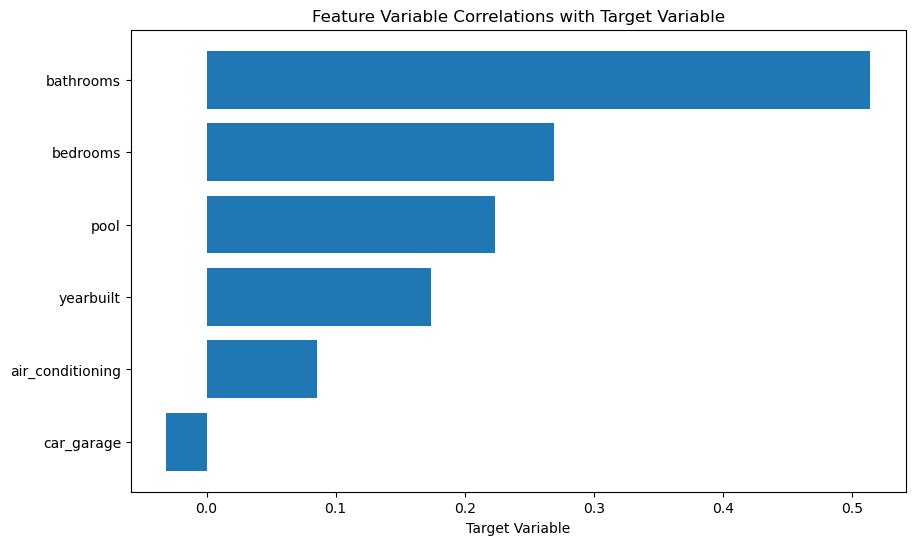

In [48]:
plot_correlations(train, target_var, feat_vars)

In [49]:
import scipy.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp, ttest_ind,f_oneway
def test_relationships(df, cat_var, cont_vars):
    # One-sample t-test for each continuous variable against the population mean
    for var in cont_vars:
        t_stat, p_value = ttest_1samp(df[var], df[var].mean())
        print(f'One-sample t-test for {var}: t={t_stat:.4f}, p={p_value:.4f}')

    # Independent t-test for each continuous variable between the two categories in the categorical variable
    for var in cont_vars:
        for cat in df[cat_var].unique():
            group1 = df[df[cat_var] == cat][var]
            group2 = df[df[cat_var] != cat][var]
            t_stat, p_value = ttest_ind(group1, group2)
            print(f'Independent t-test for {var} between {cat} and not {cat}: t={t_stat:.4f}, p={p_value:.4f}')

  # One-way ANOVA 
    for var in cont_vars:
        groups = [df[df[cat_var] == cat][var] for cat in df[cat_var].unique()]
        f_stat, p_value = f_oneway(*groups)
        print(f'One-way ANOVA for {var} by {cat_var}: F={f_stat:.4f}, p={p_value:.4f}')

In [50]:
cat_var = 'county'
cont_vars = ['yearbuilt','pool','car_garage','air_conditioning']

## Hypothesis

### 1. Having a pool affect tax value amount?

In [25]:
def plot_categorical_and_continuous_vars(df, cat_var, cont_var):
    for var in cont_var:
        # Create a box plot
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=cat_var, y=var, data=df)
        plt.axhline(y=df[var].mean(), color='r', linestyle='--')
        plt.xlabel(cat_var)
        plt.ylabel(var)
        plt.title(f'{cat_var} vs. {var}')
        plt.show()

        # Create a violin plot
        plt.figure(figsize=(12, 6))
        sns.violinplot(x=cat_var, y=var, data=df)
        plt.axhline(y=df[var].mean(), color='r', linestyle='--')
        plt.xlabel(cat_var)
        plt.ylabel(var)
        plt.title(f'{cat_var} vs. {var}')
        plt.show()

        # Create a swarm plot
        plt.figure(figsize=(12, 6))
        sns.swarmplot(x=cat_var, y=var, data=df)
        plt.axhline(y=df[var].mean(), color='r', linestyle='--')
        plt.xlabel(cat_var)
        plt.ylabel(var)
        plt.title(f'{cat_var} vs. {var}')
        plt.show()


In [51]:
cat_var = 'pool'
cont_vars = ['taxvalue']

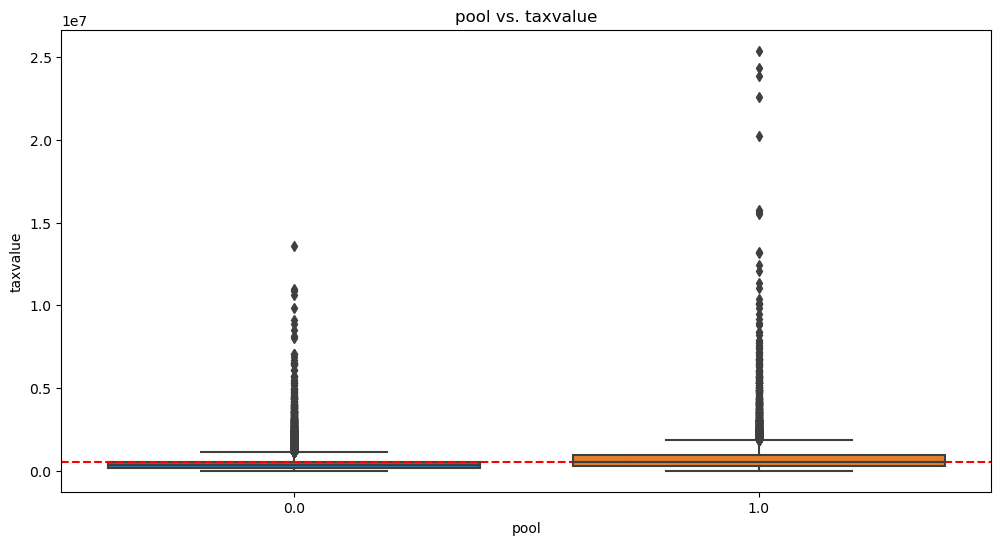

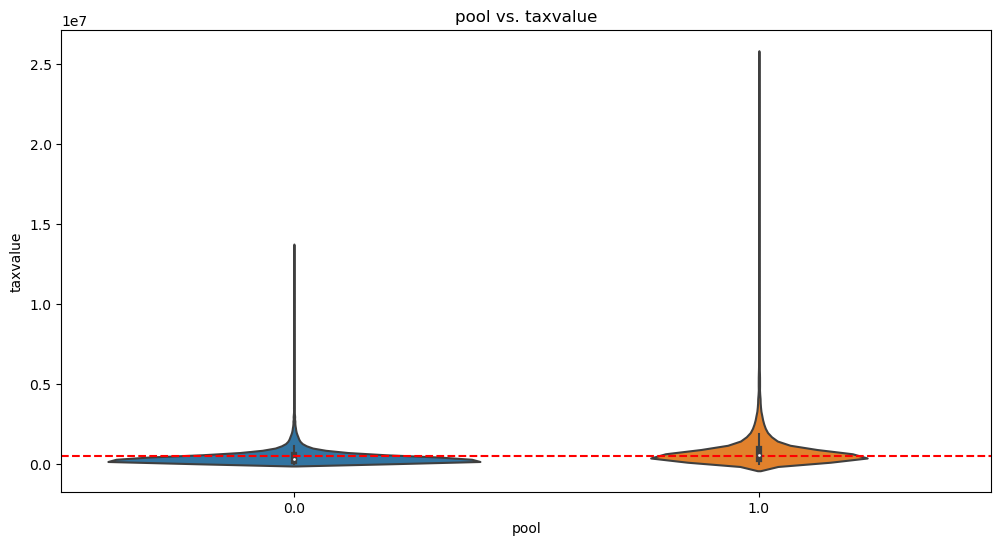

KeyboardInterrupt: 

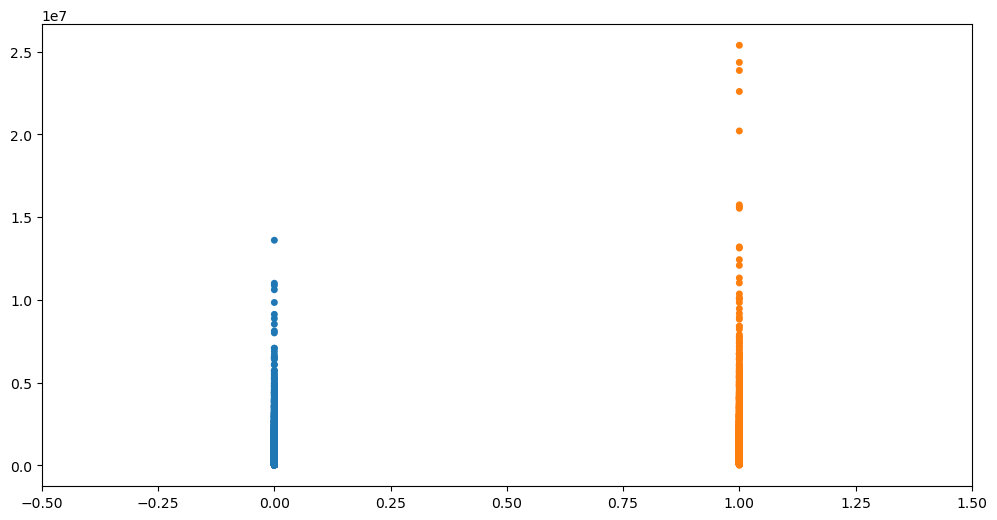

In [52]:
plot_categorical_and_continuous_vars(train,cat_var,cont_vars)

In [ ]:
test_relationships(train,cat_var,cont_vars)

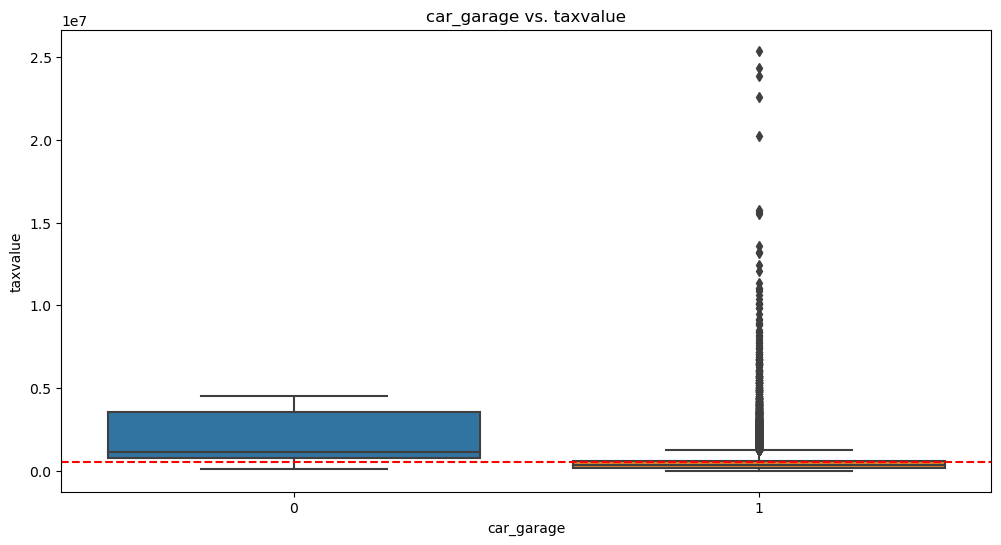

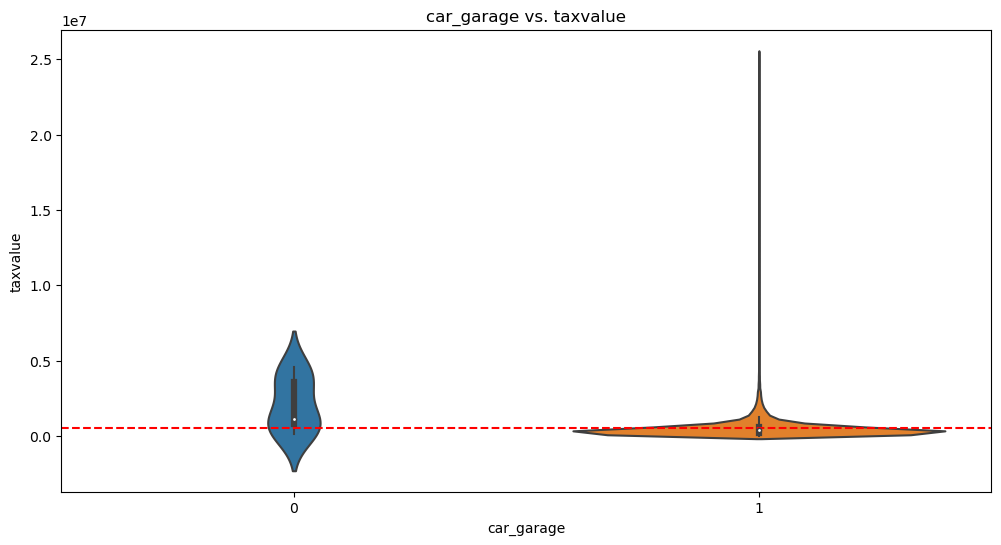

KeyboardInterrupt: 

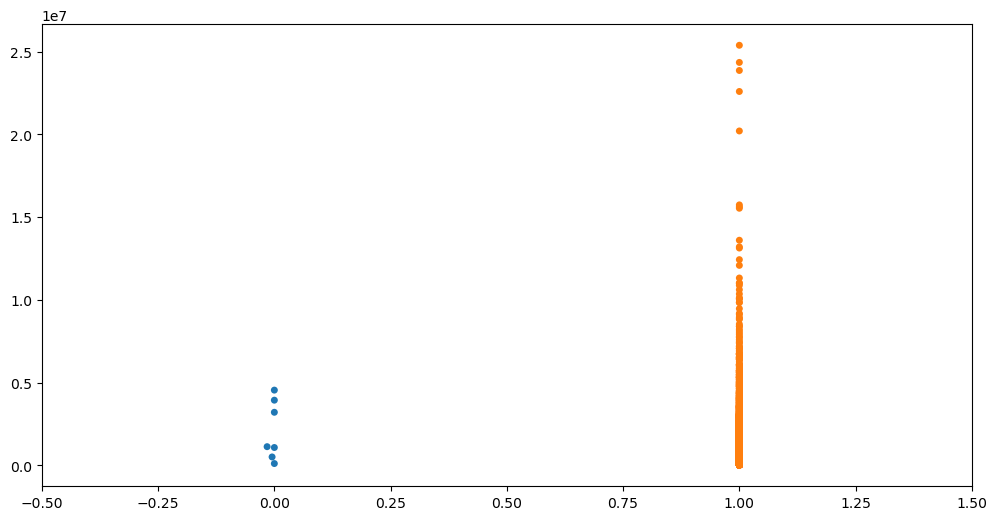

In [58]:
cat_var = 'car_garage'

cont_vars = ['taxvalue']
plot_categorical_and_continuous_vars(train,cat_var,cont_vars)

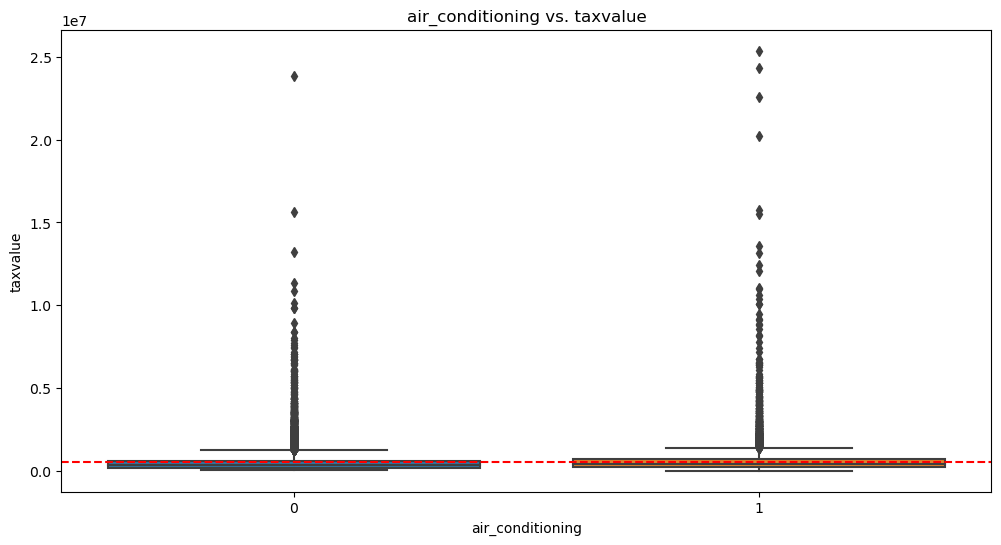

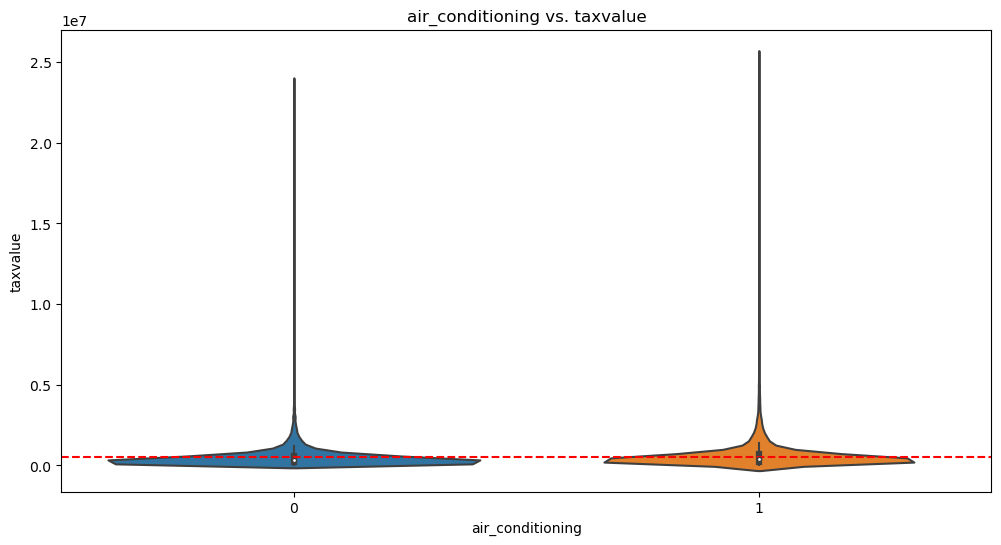

KeyboardInterrupt: 

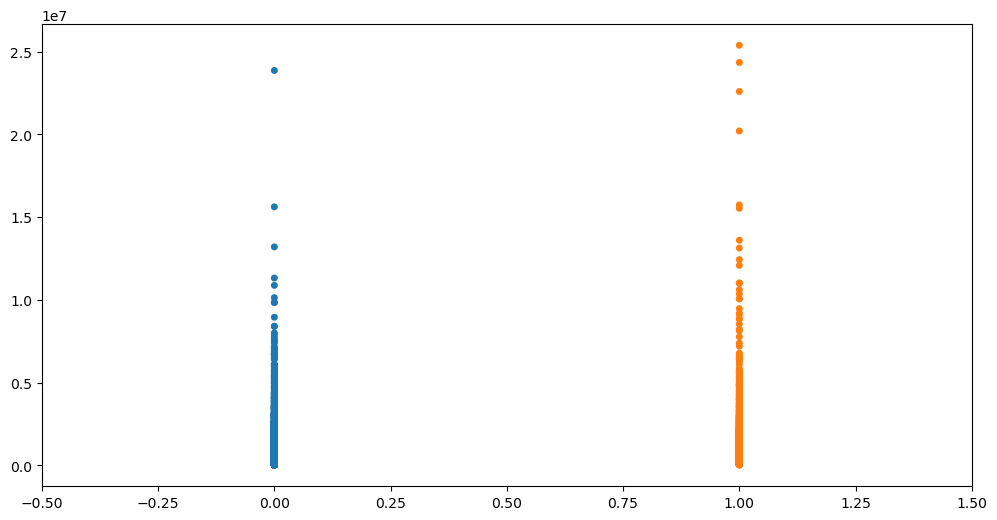

In [59]:
cat_var = 'air_conditioning'
cont_vars = ['taxvalue']
plot_categorical_and_continuous_vars(train,cat_var,cont_vars)

In [75]:
train[(train.bedrooms==3)& (train.bathrooms==2)]


,parcelid,bathrooms,bedrooms,area,yearbuilt,air_conditioning,car_garage,pool,taxvalue,county,transactiondate,LA,Orange,Ventura
1120117,13981794,2.0,3.0,1350.0,1962.0,0,1,0.0,287801.0,Orange,2017-03-27,0,1,0
1017119,12836757,2.0,3.0,1190.0,1956.0,0,1,0.0,124756.0,LA,2017-07-07,1,0,0
1192273,11820712,2.0,3.0,1263.0,1939.0,0,1,0.0,40953.0,LA,2017-07-24,1,0,0
676987,10962820,2.0,3.0,1301.0,1976.0,1,1,0.0,341194.0,LA,2017-01-20,1,0,0
1671383,13937916,2.0,3.0,1450.0,1962.0,1,1,0.0,375624.0,Orange,2017-04-25,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002800,14264194,2.0,3.0,1379.0,1969.0,0,1,0.0,279368.0,Orange,2017-07-24,0,1,0
550068,12565154,2.0,3.0,1478.0,1941.0,1,1,0.0,280112.0,LA,2017-05-23,1,0,0
762445,14465292,2.0,3.0,1478.0,1969.0,0,1,1.0,458235.0,Orange,2017-03-14,0,1,0
2037647,11031074,2.0,3.0,1273.0,1950.0,0,1,0.0,63330.0,LA,2017-09-11,1,0,0


## Feature enginering, modeling

In [85]:
x_train= train.drop(columns=['parcelid','taxvalue','county','Ventura','Orange','transactiondate'])
y_train= train.taxvalue
x_validate= validate.drop(columns=['parcelid','taxvalue','county','Ventura','Orange','transactiondate'])
y_validate=validate.taxvalue
x_test= test.drop(columns=['parcelid','taxvalue','county','Ventura','Orange','transactiondate'])
y_test=test.taxvalue

#### Scaling:

In [88]:
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

In [81]:
from sklearn.preprocessing import RobustScaler
def robust_scale_data(X_train, X_validate,X_test):
    # Initialize RobustScaler object
    scaler = RobustScaler()
    
    # Fit scaler object to training data
    scaler.fit(X_train)
    
    # Transform training and validation data
    X_train_scaled = scaler.transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)
    X_test_scaled = scaler.transform(X_test)
    # Return scaled data
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [86]:
x_train_scaled,x_validate_scaled,x_test_scaled=robust_scale_data(x_train,x_validate,x_test)

#### SelectKbest

In [89]:
kbest = SelectKBest(f_regression, k=3)
kbest.fit(x_train,y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x7ff1e6cac820>)

In [90]:
x_train.columns[kbest.get_support()]

Index(['bathrooms', 'bedrooms', 'area'], dtype='object')

#### RFE

In [92]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=3)
rfe.fit(x_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=3)

In [93]:
pd.DataFrame(
{'rfe_ranking':rfe.ranking_},
index=x_train.columns)

,rfe_ranking
bathrooms,1
bedrooms,3
area,6
yearbuilt,4
air_conditioning,1
car_garage,1
pool,2
LA,5


## Sequential Feature Selector

In [94]:
def sequential_feature_selector(X, y, k):
    """
    Select the top k features based on the Sequential Feature Selector class.
    Returns:
        List of str: The names of the top k selected features.
    """
    # Create the SequentialFeatureSelector object and fit it to the data
    estimator = LinearRegression()
    selector = SequentialFeatureSelector(estimator, n_features_to_select=k, direction='forward', scoring='neg_mean_squared_error', cv=5)
    selector.fit(X, y)
    
    # Get the mask of the top k selected features
    feature_mask = selector.get_support()
    
    # Get the names of the top k selected features
    feature_names = list(X.columns[feature_mask])
    
    return feature_names


In [95]:
sequential_feature_selector(x_train,y_train,3)

['bedrooms', 'area', 'yearbuilt']

In [101]:
x_train_scaled = pd.DataFrame(x_train_scaled, columns = x_train.columns)

x_validate_scaled = pd.DataFrame(x_validate_scaled, columns=x_validate.columns)
x_test_scaled=pd.DataFrame(x_test_scaled, columns=x_test.columns)

### Modeling

features: bathrooms, bedrooms, car_garage

In [241]:
x_train_rfe=x_train_scaled[['area','bathrooms','bedrooms','air_conditioning']]
x_val_rfe=x_validate_scaled[['area','bathrooms','bedrooms','air_conditioning']]
x_test_rfe=x_test_scaled[['area','bathrooms','bedrooms','air_conditioning']]

In [242]:
# yhat:
yhat=y_train.mean()
yhat
yhat= np.repeat(yhat, len(train))

In [243]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [244]:
rmse,r2=metrics_reg(y_train,yhat)
rmse,r2

(731760.0292301582, 0.0)

In [245]:
metrics= pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics

,model,rmse,r2
0,baseline,731760.02923,0.0


## Ordinary Least Squares (OLS)

In [246]:
lr=LinearRegression()
lr.fit(x_train_rfe,y_train)
pred_lr=lr.predict(x_train_rfe)
pred_val_lr=lr.predict(x_val_rfe)

In [247]:
metrics_reg(y_train,pred_lr)

(577806.8439811162, 0.3765121475368387)

In [248]:
rmse,r2=metrics_reg(y_validate,pred_val_lr)
rmse,r2

(481305.86398753297, 0.43971780162668017)

In [249]:
metrics.loc[1]=("Ols",rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718


### LassoLARS

In [250]:
lars=LassoLars(alpha=1)
lars.fit(x_train_scaled,y_train)
pred_lars=lars.predict(x_train_scaled)
pred_val_lars=lars.predict(x_validate_scaled)

In [251]:
metrics_reg(y_train,pred_lars)

(573195.7487753596, 0.3864237305868312)

In [252]:
rmse,r2=metrics_reg(y_validate,pred_val_lars)
rmse,r2

(478459.8225614758, 0.44632429425018394)

In [253]:
metrics.loc[2]=('lars',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324


In [254]:
lars=LassoLars(alpha=2)
lars.fit(x_train_scaled,y_train)
pred_lars=lars.predict(x_train_scaled)
pred_val_lars=lars.predict(x_validate_scaled)

In [255]:
rmse,r2=metrics_reg(y_validate,pred_val_lars)
rmse,r2

(478434.2496736778, 0.4463834787736992)

In [256]:
metrics.loc[3]=('lars2',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324
3,lars2,478434.249674,0.446383


In [257]:
lars=LassoLars(alpha=3)
lars.fit(x_train_scaled,y_train)
pred_lars=lars.predict(x_train_scaled)
pred_val_lars=lars.predict(x_validate_scaled)

In [258]:
rmse,r2=metrics_reg(y_validate,pred_val_lars)
rmse,r2

(478409.49631993106, 0.4464407635984885)

In [259]:
metrics.loc[4]=('lars3',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324
3,lars2,478434.249674,0.446383
4,lars3,478409.496320,0.446441


### Polynomial Regression

In [260]:
pf = PolynomialFeatures(degree=2)

In [261]:
x_degree=pf.fit_transform(x_train_scaled,y_train)
x_val_degree=pf.transform(x_validate_scaled)
pr=LinearRegression()

In [262]:
pr.fit(x_degree,y_train)
pred_pf=pr.predict(x_degree)
pred_val_pf=pr.predict(x_val_degree)


In [263]:
rmse,r2=metrics_reg(y_validate,pred_val_pf)

In [264]:
metrics.loc[5]=('pf_deg2',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324
3,lars2,478434.249674,0.446383
4,lars3,478409.496320,0.446441
5,pf_deg2,466754.337621,0.473084


In [265]:
pf = PolynomialFeatures(degree=3)
x_degree=pf.fit_transform(x_train_scaled,y_train)
x_val_degree=pf.transform(x_validate_scaled)
pr=LinearRegression()
pr.fit(x_degree,y_train)
pred_pf=pr.predict(x_degree)
pred_val_pf=pr.predict(x_val_degree)


In [266]:
rmse,r2=metrics_reg(y_validate,pred_val_pf)

In [267]:
metrics.loc[6]=('pf_deg3',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324
3,lars2,478434.249674,0.446383
4,lars3,478409.496320,0.446441
5,pf_deg2,466754.337621,0.473084
6,pf_deg3,465129.449454,0.476746


In [268]:
pf = PolynomialFeatures(degree=1)
x_degree=pf.fit_transform(x_train_scaled,y_train)
x_val_degree=pf.transform(x_validate_scaled)
pr=LinearRegression()
pr.fit(x_degree,y_train)
pred_pf=pr.predict(x_degree)
pred_val_pf=pr.predict(x_val_degree)

In [269]:
rmse,r2=metrics_reg(y_validate,pred_val_pf)

In [270]:
metrics.loc[7]=('pf_deg1',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324
3,lars2,478434.249674,0.446383
4,lars3,478409.496320,0.446441
5,pf_deg2,466754.337621,0.473084
6,pf_deg3,465129.449454,0.476746
7,pf_deg1,478486.214852,0.446263


### Generalized linear model

In [271]:
glm = TweedieRegressor(power=0, alpha=0)

In [272]:
glm.fit(x_train_scaled,y_train)
pred_glm = glm.predict(x_train_scaled)
pred_val_glm = glm.predict(x_validate_scaled)

In [273]:
rmse,r2=metrics_reg(y_validate,pred_val_glm)

In [274]:
metrics.loc[8]=('glm0,0',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324
3,lars2,478434.249674,0.446383
4,lars3,478409.496320,0.446441
5,pf_deg2,466754.337621,0.473084
6,pf_deg3,465129.449454,0.476746
7,pf_deg1,478486.214852,0.446263
8,"glm0,0",478486.216743,0.446263


In [275]:
glm = TweedieRegressor(power=1, alpha=1)

In [276]:
glm.fit(x_train_scaled,y_train)
pred_glm = glm.predict(x_train_scaled)
pred_val_glm = glm.predict(x_validate_scaled)

In [277]:
rmse,r2=metrics_reg(y_validate,pred_val_glm)

In [278]:
metrics.loc[9]=('glm1,1',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324
3,lars2,478434.249674,0.446383
4,lars3,478409.496320,0.446441
5,pf_deg2,466754.337621,0.473084
6,pf_deg3,465129.449454,0.476746
7,pf_deg1,478486.214852,0.446263
8,"glm0,0",478486.216743,0.446263
9,"glm1,1",497724.392126,0.400841


In [279]:
glm = TweedieRegressor(power=2, alpha=2)
glm.fit(x_train_scaled,y_train)
pred_glm = glm.predict(x_train_scaled)
pred_val_glm = glm.predict(x_validate_scaled)

In [280]:
rmse,r2=metrics_reg(y_validate,pred_val_glm)

In [281]:
metrics.loc[10]=('glm2,2',rmse,r2)
metrics

,model,rmse,r2
0,baseline,731760.029230,0.000000
1,Ols,481305.863988,0.439718
2,lars,478459.822561,0.446324
3,lars2,478434.249674,0.446383
4,lars3,478409.496320,0.446441
5,pf_deg2,466754.337621,0.473084
6,pf_deg3,465129.449454,0.476746
7,pf_deg1,478486.214852,0.446263
8,"glm0,0",478486.216743,0.446263
9,"glm1,1",497724.392126,0.400841
